In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution  # for comparison to SCA
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import shap
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

#from base1 import *
from base2 import *
from XGB_func import *

X_train_1 = pd.read_csv('csv/CX_train_eu.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/Cy_train_eu.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/CX_val_eu.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/Cy_val_eu.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/CX_test_eu.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/Cy_test_eu.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

# Ensure binary target variable is numerical
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1 

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder on X_train and transform on all sets to ensure consistency
X_train['X141'] = label_encoder.fit_transform(X_train['X140'])
X_val['X141'] = label_encoder.transform(X_val['X140'])
X_test['X141'] = label_encoder.transform(X_test['X140'])
# Drop column 'X140' from each DataFrame
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

<ipython-input-4-64e5dd2a4066>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-4-64e5dd2a4066>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-4-64e5dd2a4066>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

In [ ]:
# Fit LabelEncoder on X_train['Country']
label_encoder = LabelEncoder()
label_encoder.fit(X_train['Country'])

# Function to transform with handling for unseen labels
def safe_transform(encoder, values):
    classes = encoder.classes_
    unseen_label = np.max(encoder.transform(classes)) + 1  # Assign a new label for unseen
    value_to_index = {label: idx for idx, label in enumerate(classes)}
    return [value_to_index.get(val, unseen_label) for val in values]

# Transform all sets
X_train['X200'] = label_encoder.transform(X_train['Country'])
X_val['X200'] = safe_transform(label_encoder, X_val['Country'])
X_test['X200'] = safe_transform(label_encoder, X_test['Country'])

# Drop 'Country' column
X_train = X_train.drop(columns=['Country'])
X_val = X_val.drop(columns=['Country'])
X_test = X_test.drop(columns=['Country'])

In [ ]:
# Deal with missing values in the features 
missing_threshold = 0.8
missing_train = X_train.isnull().mean()
cols_to_drop = missing_train[missing_train > missing_threshold].index
# Drop the identified columns from both the training and test sets
X_train = X_train.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
print(f"Columns dropped: {list(cols_to_drop)}")
print(len(cols_to_drop))

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X141")
col_names.remove("X200")

Columns dropped: ['X20', 'X119']
2


In [ ]:
# remove outliers
col_25perc = round(len(X_train.columns)*0.25)
total_class = y_train.value_counts().to_dict()
X_train, y_train, removed_counts = k.remove_outliers_iqr(X_train, y_train, col_names, min_outliers= col_25perc)
print("Perc rows removed class 1:", removed_counts[1]/total_class[1])
print("Perc rows removed class 0:", removed_counts[0]/total_class[0])


# Deal with missing values
max_missing = col_25perc
X_train = X_train[X_train.isnull().sum(axis=1) < max_missing]
y_train = y_train.loc[X_train.index]
new_total_class = y_train.value_counts().to_dict()
print("Perc rows removed class 1:", (new_total_class[1]-(total_class[1]-removed_counts[1]))/(total_class[1]-removed_counts[1]))
print("Perc rows removed class 0:", (new_total_class[0]-(total_class[0]-removed_counts[0]))/(total_class[0]-removed_counts[0]))

# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

Perc rows removed class 1: 0.14154233675644254
Perc rows removed class 0: 0.15912246598167176
Perc rows removed class 1: -0.29184065003949894
Perc rows removed class 0: -0.18031704095112286


In [ ]:
# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [ ]:
# Scale the data
X_train, X_val, X_test = k.scale_columns1(X_train, X_val, X_test, col_names)
print("Data has been split, outliers removed, and data scaled.")

Data has been split, outliers removed, and data scaled.


In [ ]:
best_params = {'learning_rate': 0.03693727433705628, 'max_depth': 9.56202448143557, 'subsample': 0.7535782154795646, 'colsample_bytree': 0.5989401990102827, 'reg_alpha': 0.0, 'reg_lambda': 0.3198199926573602}

In [ ]:
final_kappa, final_misclass_error, final_model = train_xgboost(X_train, y_train, X_val, y_val, best_params)

In [ ]:
# Output final model evaluation
print(f"Final Model Cohen's Kappa: {final_kappa}")
print(f"Final Model Misclassification Error: {final_misclass_error}")
# Evalute 
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

Final Model Cohen's Kappa: 0.7614025210247943
Final Model Misclassification Error: 0.08315473639091298
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1267
           1       0.91      0.97      0.94      3402

    accuracy                           0.91      4669
   macro avg       0.91      0.85      0.87      4669
weighted avg       0.91      0.91      0.90      4669



In [ ]:
# Save the trained XGBoost model
final_model.save_model("eu_xgboost_241119.json")
# Load the saved XGBoost model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("eu_xgboost_241119.json")
# Verify by running predictions
y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1267
           1       0.91      0.97      0.94      3402

    accuracy                           0.91      4669
   macro avg       0.91      0.85      0.87      4669
weighted avg       0.91      0.91      0.90      4669



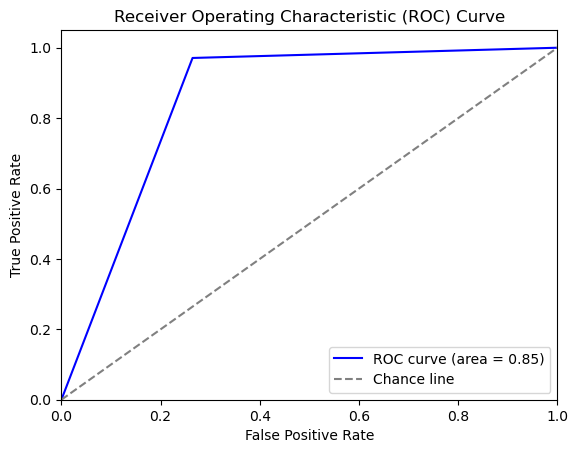

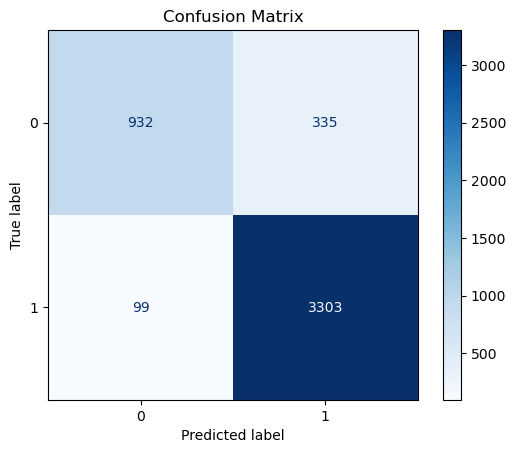

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_test
y_pred_proba = y_pred 
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("results/241119 EU+C/Plots/XGB_roc_curve_smote.png", dpi=300, bbox_inches='tight')
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("results/241119 EU+C/Plots/XGB_confusion_matrix_smote.png", dpi=300, bbox_inches='tight')
plt.show()

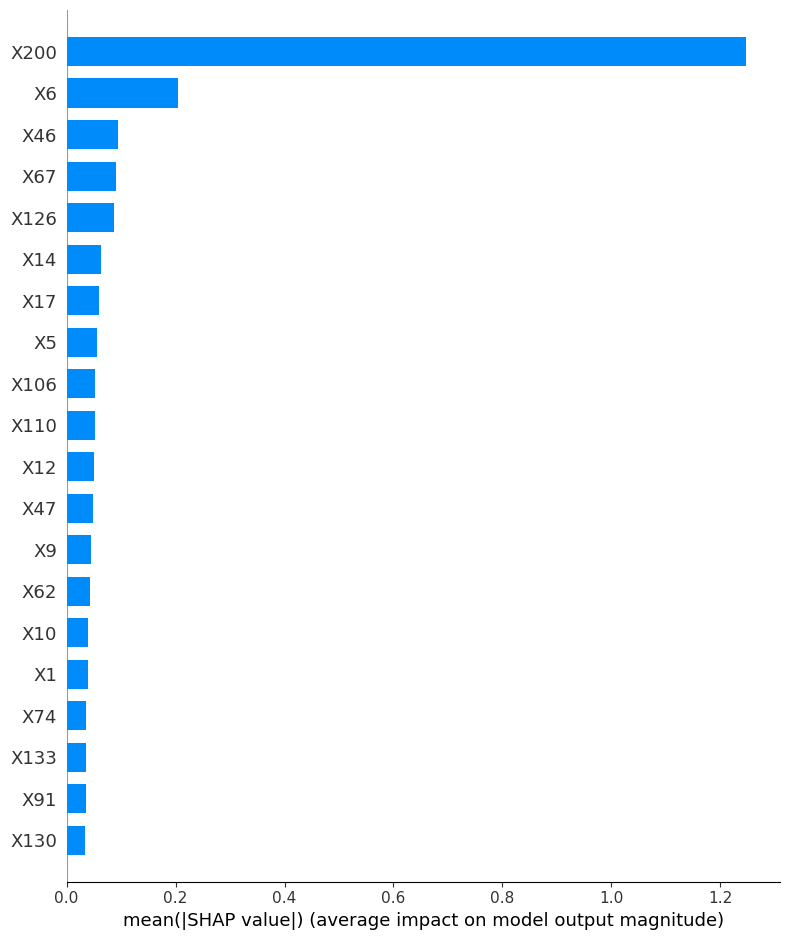

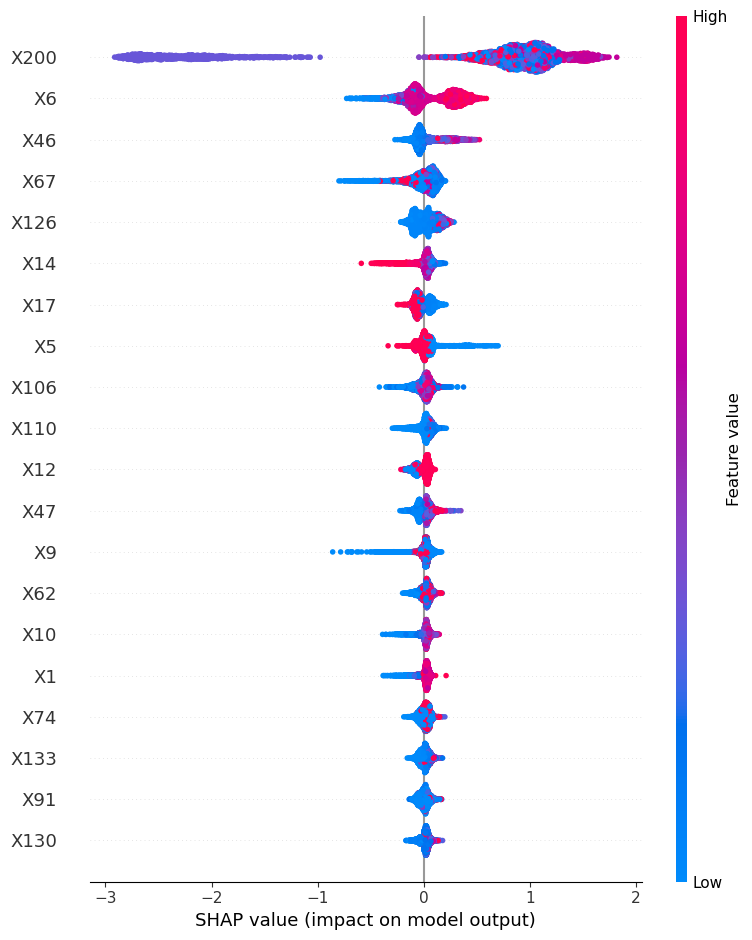

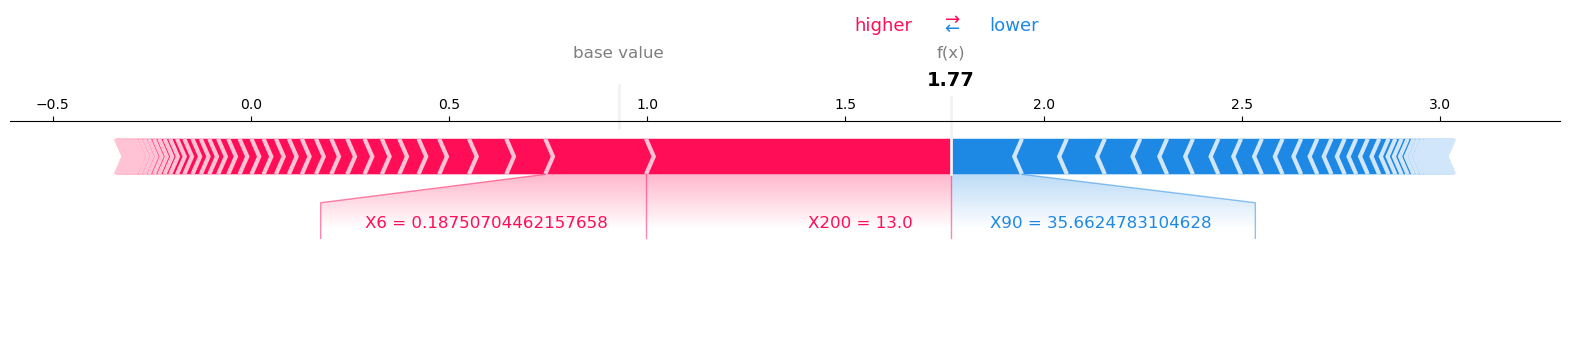

Elapsed time: 3.5148 seconds


In [ ]:
import time
# Start the timer
start_time = time.time()
import shap
import matplotlib.pyplot as plt
final_model.get_booster().feature_names = X_train.columns.tolist()  # Ensure feature names are set for SHAP
# 1. Initialize SHAP explainer
explainer = shap.TreeExplainer(final_model)
# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)
# -------------------------
# Global Interpretability
# -------------------------
# Summary plot - Feature importance (global)
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Feature importance as a bar chart
# Summary plot - Feature effects (global)
shap.summary_plot(shap_values, X_test)  # Feature effects as a scatter plot
# -------------------------
# Local Interpretability
# -------------------------
# Single prediction force plot
sample_index = 0  # Choose a specific instance from the test set
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index],
    X_test.iloc[sample_index],
    matplotlib=True
)
# Save as PNG
plt.savefig("results/241119 EU+C/Plots/XGBoost_single.png", bbox_inches='tight')
plt.close()

# Multiple predictions force plot (interactive)
cohort_force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[:100],  # Visualize the first 100 samples
    X_test.iloc[:100]
)
# Save as HTML
shap.save_html("results/241119 EU+C/Plots/XGBoost_multiple.html", cohort_force_plot)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")